# Setting

## Libraries

In [1]:
library(quantmod)
library(forecast)
library(rugarch)


#library(lattice)
#library(timeSeries)


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [2]:
source("~/works/utils/r/myutils.r")
source("~/works/utils/r/myarimagarch.r")

## Data

In [3]:
train_start <- '1991-01-01'
train_end <- '2019-12-31'

test_start <- '2020-01-01'
test_end <- '2020-12-31'

In [4]:
from <- train_start
to <- test_end
getSymbols("^GSPC", from=from, to=to)

[1] "^GSPC"

In [5]:
spx <- GSPC
colnames(spx) <- c('o','h','l','c','v','a')

In [6]:
# daily log. return
spx.ret <- diff(log(spx$a))
colnames(spx.ret) <- 'logret'

In [7]:
train <- window(spx.ret, end=as.Date(train_end))
test <- window(spx.ret, start=as.Date(test_start), end=as.Date(test_end))

## CV Settings

In [8]:
YEAR <- 252
hori <- 21
peri <- floor(hori/2)
#wind <- 5*YEAR
wind <- 7*YEAR

In [9]:
# testing
train_start <- '1991-01-01'
#train_end <- '2000-12-31'
train_end <- '1998-12-31'
train <- window(spx.ret, start=as.Date(train_start), end=as.Date(train_end))

In [10]:
n <- (nrow(train) - wind - hori)/floor(peri)
print(paste('number of iterations: ', round(n), sep=''))

[1] "number of iterations: 24"


# Prophet

## Setting

In [11]:
library(prophet)
library(dplyr)

Loading required package: Rcpp

Loading required package: rlang


Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [51]:
prophet.CV <- function(train, window, period, horizon, args.bdate=TRUE, xreg.names=NULL) {
    m <- prophet(train)
    if (!is.null(xreg.names)) {
        for (x in xreg.names) {
            m <- add_regressor(m, x)
        }
    }
    if (args.bdate) {
        f <- function(x) round(x * 365 / YEAR)
        window <- f(window)
        period <- f(period)
        horizon <- f(horizon)
    }
    result <- cross_validation(m, initial=window, period=period, horizon=horizon, units='days')
    result <- prophet.calError(result, train$ds, horizon)
    return(result)
}



prophet.calError <- function(result, ds, hori) {
    result[,'se'] <- (result$y - result$yhat)^2
    result[,'pe'] <- abs((1 - result$yhat/result$y))

    result <- (result %>% group_by(cutoff) 
               %>% summarise(rmse = mean(se), 
                             mape = mean(pe),
                             .groups = 'drop'))
    result[,'rmse'] <- sqrt(result[,'rmse'])
    colnames(result) <- c('forecast_start', 'rmse', 'mape')

    result[,'forecast_start'] <- apply(result[,'forecast_start'], 1, 
                                       #function(x){match(as.Date(x), index(train))})
                                       function(x){match(as.Date(x), ds)})
    result[,'forecast_start'] <- result[,'forecast_start'] + 1
    result[,'forecast_end'] <- result[,'forecast_start'] + hori - 1

    result <- result[,c(1,4,2,3)]
    return(result)
}

## Basic

In [17]:
train.p <- data.frame(ds=index(train), y=as.numeric(train))
result.1 <- prophet.CV(train.p, wind, peri, hori)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Making 24 forecasts with cutoffs between 1998-01-13 and 1998-12-01



## Additional regressors

### Regressors

In [41]:
x <- RSI(spx$a)
trainx <- merge(train, x, join='left', fill=NA)

In [42]:
# use close instead of adjusted to make consistent with "un-adjusted" high & low
x <- BBands(spx[,c('h','l','c')])
x <- x$pctB
trainx <- merge(trainx, x, join='left', fill=NA)

In [43]:
x <- MACD(spx$a)
x <- x$macd - x$signal
trainx <- merge(trainx, x, join='left', fill=NA)

In [44]:
colnames(trainx) <- c('y','rsi','bbands','macd')
trainx <- na.omit(trainx)
#head(trainx)

In [45]:
train.p <- as.data.frame(trainx)
train.p <- cbind(ds = rownames(train.p), train.p)
rownames(train.p) <- NULL
head(train.p)

ds         y             rsi      bbands    macd       
1 1991-02-19  0.0008938101 72.59254 0.8419486 -0.03641515
2 1991-02-20 -0.0115721543 66.25313 0.7706927 -0.18551057
3 1991-02-21 -0.0004657216 66.00481 0.7330987 -0.30953562
4 1991-02-22  0.0018614141 66.54491 0.7402938 -0.39546732
5 1991-02-25  0.0043934960 67.84742 0.7305630 -0.43573971
6 1991-02-26 -0.0121907956 60.80133 0.6379610 -0.55105032

In [53]:
#result.2 <- prophet.CV(train.p, wind, peri, hori, xreg.names=colnames(train.p)[3:5])
result.2 <- prophet.CV(train.p, wind, peri, hori, xreg.names=c('macd'))

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



ERROR: Error in add_regressor(m, x): Regressors must be added prior to model fitting.


In [56]:
head(train.p[,1:3])

ds         y             rsi     
1 1991-02-19  0.0008938101 72.59254
2 1991-02-20 -0.0115721543 66.25313
3 1991-02-21 -0.0004657216 66.00481
4 1991-02-22  0.0018614141 66.54491
5 1991-02-25  0.0043934960 67.84742
6 1991-02-26 -0.0121907956 60.80133

In [57]:
m <- prophet()
m <- add_regressor(m, 'rsi')
m <- fit.prophet(m, train.p[,1:3])


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



ds         y             rsi         floor t            y_scaled    
1    1991-02-19  0.0008938101  1.46101545 0     0.0000000000  0.012566312
2    1991-02-20 -0.0115721543  0.89603034 0     0.0003481894 -0.162695984
3    1991-02-21 -0.0004657216  0.87389934 0     0.0006963788 -0.006547703
4    1991-02-22  0.0018614141  0.92203438 0     0.0010445682  0.026170115
5    1991-02-25  0.0043934960  1.03811776 0     0.0020891365  0.061769325
6    1991-02-26 -0.0121907956  0.41015107 0     0.0024373259 -0.171393626
7    1991-02-27  0.0134968638  0.79528800 0     0.0027855153  0.189755985
8    1991-02-28 -0.0018235549  0.70313115 0     0.0031337047 -0.025637842
9    1991-03-01  0.0092198879  0.95868616 0     0.0034818942  0.129624847
10   1991-03-04 -0.0030819544  0.79145547 0     0.0045264624 -0.043330013
11   1991-03-05  0.0198116905  1.30069514 0     0.0048746518  0.278537807
12   1991-03-06 -0.0014610052  1.21902309 0     0.0052228412 -0.020540659
13   1991-03-07 -0.0006914398  1.17824921 0     0.0055710306 -0.009721135
14   1991-03-08 -0.0025570479  1.02127371 0     0.0059192201 -0.035950214
15   1991-03-11 -0.0053215646  0.69803923 0     0.0069637883 -0.074817287
16   1991-03-12 -0.0078870704  0.25099024 0     0.0073119777 -0.110886413
17   1991-03-13  0.0121946393  0.67326981 0     0.0076601671  0.171447666
18   1991-03-14 -0.0028607155  0.51129792 0     0.0080083565 -0.040219557
19   1991-03-15  0.0002409241  0.52003462 0     0.0083565460  0.003387216
20   1991-03-18 -0.0039694595  0.27886436 0     0.0094011142 -0.055807683
21   1991-03-19 -0.0149454227 -0.50944282 0     0.0097493036 -0.210121659
22   1991-03-20  0.0036215121 -0.34507847 0     0.0100974930  0.050915799
23   1991-03-21 -0.0036488155 -0.52621973 0     0.0104456825 -0.051299664
24   1991-03-22  0.0024521823 -0.40516454 0     0.0107938719  0.034475880
25   1991-03-25  0.0063744801 -0.09770138 0     0.0118384401  0.089620505
26   1991-03-26  0.0173432603  0.60104197 0     0.0121866295  0.243833492
27   1991-03-27 -0.0025277257  0.45030653 0     0.0125348189 -0.035537966
28   1991-03-28 -0.0003464167  0.42877381 0     0.0128830084 -0.004870365
29   1991-04-01 -0.0105021944 -0.18860564 0     0.0142757660 -0.147653135
30   1991-04-02  0.0218442680  0.64492127 0     0.0146239554  0.307114353
⋮    ⋮          ⋮             ⋮           ⋮     ⋮            ⋮           
1961 1998-11-18  0.0045188221  1.25950440 0     0.9850279     0.063531317
1962 1998-11-19  0.0070785551  1.43638961 0     0.9853760     0.099519282
1963 1998-11-20  0.0094467957  1.65443670 0     0.9857242     0.132815005
1964 1998-11-23  0.0209722214  2.05173164 0     0.9867688     0.294854019
1965 1998-11-24 -0.0044028168  1.77843942 0     0.9871170    -0.061900368
1966 1998-11-25  0.0032744622  1.84230950 0     0.9874652     0.046036532
1967 1998-11-27  0.0045897534  1.93210291 0     0.9881616     0.064528560
1968 1998-11-30 -0.0243649054  0.55915283 0     0.9892061    -0.342552662
1969 1998-12-01  0.0099620081  0.82534229 0     0.9895543     0.140058512
1970 1998-12-02 -0.0034348872  0.65734528 0     0.9899025    -0.048291989
1971 1998-12-03 -0.0181878674 -0.13443469 0     0.9902507    -0.255708048
1972 1998-12-04  0.0228642076  0.50924609 0     0.9905989     0.321453955
1973 1998-12-07  0.0092707278  0.73347452 0     0.9916435     0.130339619
1974 1998-12-08 -0.0053353716  0.50720390 0     0.9919916    -0.075011404
1975 1998-12-09  0.0017844411  0.55465232 0     0.9923398     0.025087930
1976 1998-12-10 -0.0157294206 -0.09274519 0     0.9926880    -0.221144092
1977 1998-12-11  0.0012352164 -0.05407749 0     0.9930362     0.017366235
1978 1998-12-14 -0.0218931904 -0.81976322 0     0.9940808    -0.307802166
1979 1998-12-15  0.0187763539 -0.23058288 0     0.9944290     0.263981736
1980 1998-12-16 -0.0007656801 -0.25684772 0     0.9947772    -0.010764900
1981 1998-12-17  0.0154065010  0.18888983 0     0.9951253     0.216604081
1982 1998-12-18  0.0067990253  0.37077918 0     0.9954735     0.095589299
1983 1998

In [58]:
tail(m$history)

ds         y             rsi       floor t         y_scaled   
1985 1998-12-23  0.0205344089 1.1689175 0     0.9972145  0.28869870
1986 1998-12-24 -0.0018494463 1.0813686 0     0.9975627 -0.02600186
1987 1998-12-28 -0.0006363021 1.0495964 0     0.9989554 -0.00894594
1988 1998-12-29  0.0132292844 1.3498021 0     0.9993036  0.18599402
1989 1998-12-30 -0.0079879511 0.9417441 0     0.9996518 -0.11230472
1990 1998-12-31 -0.0021941483 0.8314396 0     1.0000000 -0.03084811

In [ ]:
future$nfl_sunday <- nfl_sunday(future$ds)

forecast <- predict(m, future)
prophet_plot_components(m, forecast)

In [ ]:
https://github.com/facebook/prophet/blob/main/R/R/prophet.R

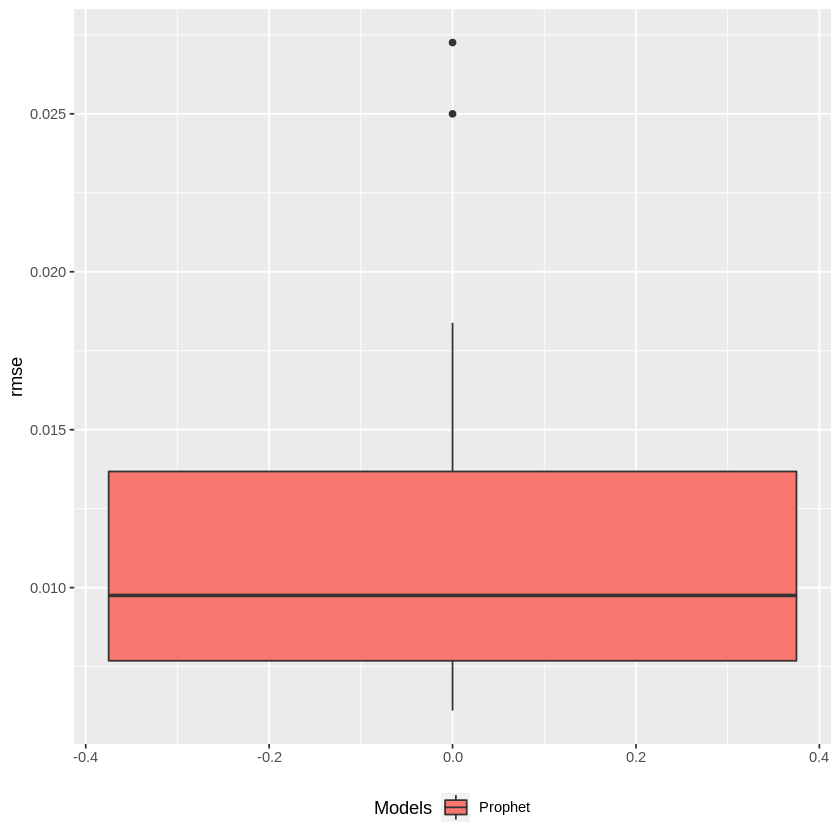

In [19]:
errors <- my.get_result(result.1, 'Prophet')
my.plot_errors(errors, metrics=c('rmse'))

# ARIMA

In [50]:
cv.forecast <- function(x, h) {
    forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                        #allowdrift=TRUE, allowmean = TRUE, # default
                        lambda="auto"), h=h)
}

In [51]:
result.m02 <- my.tsCV(train, cv.forecast, h=hori, window=wind, step=peri)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -12252.31
 ARIMA(0,0,0) with non-zero mean : -12248.37
 ARIMA(1,0,0) with non-zero mean : -12247.25
 ARIMA(0,0,1) with non-zero mean : -12246.81
 ARIMA(0,0,0) with zero mean     : 5005.842
 ARIMA(1,0,2) with non-zero mean : -12263.59
 ARIMA(0,0,2) with non-zero mean : -12245.56
 ARIMA(1,0,1) with non-zero mean : -12245.25
 ARIMA(1,0,3) with non-zero mean : -12261.66
 ARIMA(0,0,3) with non-zero mean : -12247.24
 ARIMA(2,0,1) with non-zero mean : -12251.02
 ARIMA(2,0,3) with non-zero mean : -12253.57
 ARIMA(1,0,2) with zero mean     : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,2) with non-zero mean : -12248.74

 Best model: ARIMA(1,0,2) with non-zero mean 


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -12263.54
 ARIMA(0,0,0) with non-zero mean : -12253.43
 ARIMA(1,0,0) with non-zero mean : -12253.68
 ARIMA(0,0

In [52]:
x <- result.m02
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


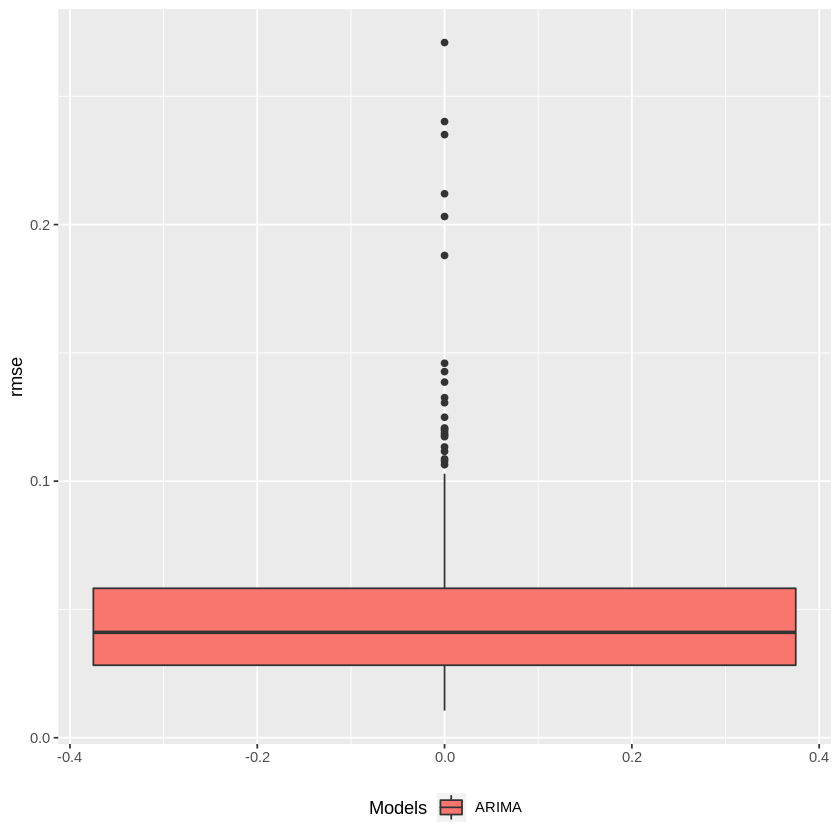

In [13]:
errors.m02 <- my.get_result(result.m02, 'ARIMA')
my.plot_errors(errors.m02, metrics=c('rmse'))

# Regression with ARIMA errors

## Setting

### Regressors

In [14]:
x <- RSI(spx$a)
trainx <- merge(train, x, join='left', fill=NA)

In [15]:
# use close instead of adjusted to make consistent with "un-adjusted" high & low
x <- BBands(spx[,c('h','l','c')])
x <- x$pctB
trainx <- merge(trainx, x, join='left', fill=NA)

In [16]:
x <- MACD(spx$a)
x <- x$macd - x$signal
trainx <- merge(trainx, x, join='left', fill=NA)

In [17]:
colnames(trainx) <- c('logret','rsi','bbands','macd')
trainx <- na.omit(trainx)
head(trainx)

                  logret      rsi    bbands        macd
1991-02-19  0.0008938101 72.59254 0.8419486 -0.03641515
1991-02-20 -0.0115721543 66.25313 0.7706927 -0.18551057
1991-02-21 -0.0004657216 66.00481 0.7330987 -0.30953562
1991-02-22  0.0018614141 66.54491 0.7402938 -0.39546732
1991-02-25  0.0043934960 67.84742 0.7305630 -0.43573971
1991-02-26 -0.0121907956 60.80133 0.6379610 -0.55105032

## Basic

In [18]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL) {
    
    if (!is.null(xreg)) {
        
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }
        
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        #colnames(xreg.h) <- colnames(xreg) # error with multiple xreg
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        
    } else {
        xreg.h <- NULL
    }
    
    fc <- forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                              xreg=xreg, 
                              #lambda="auto" # not for negative value
                              ), h=h, xreg=xreg.h)
    return(fc)
}

In [19]:
result.m03.1 <- my.tsCV(trainx[,1], cv.forecast, h=hori, window=wind, step=peri,
                      silent=F,
                      xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -13090.73
 Regression with ARIMA(0,0,0) errors : -12481.33
 Regression with ARIMA(1,0,0) errors : -12481.38
 Regression with ARIMA(0,0,1) errors : -12480.83
 Regression with ARIMA(0,0,0) errors : -12381.52
 Regression with ARIMA(1,0,2) errors : -12482.89
 Regression with ARIMA(2,0,1) errors : -12481.71
 Regression with ARIMA(3,0,2) errors : -13113.99
 Regression with ARIMA(3,0,1) errors : Inf
 Regression with ARIMA(4,0,2) errors : -13085.22
 Regression with ARIMA(3,0,3) errors : -13121.87
 Regression with ARIMA(2,0,3) errors : Inf
 Regression with ARIMA(4,0,3) errors : -13113.33
 Regression with ARIMA(3,0,4) errors : -13121.99
 Regression with ARIMA(2,0,4) errors : -13095.36
 Regression with ARIMA(4,0,4) errors : -13124.65
 Regression with ARIMA(5,0,4) errors : -13115.73
 Regression with ARIMA(4,0,5) errors : -13124.6
 Regression with ARIMA(3,0,5) errors : -13123.9
 Regression with ARIMA

In [20]:
x <- result.m03.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


## Normalize data

In [21]:
mins <- t(apply(trainx, 2, min))
maxs <- t(apply(trainx, 2, max))
print(data.frame(rbind(mins, maxs), row.names=c('min','max')))

         logret      rsi     bbands      macd
min -0.09469512 13.63935 -0.4188305 -2.499158
max  0.10957197 86.68665  1.3157451  1.865475


In [22]:
cv.forecast.norm <- function(x, h, xreg=NULL, xreg.msize=NULL) {
    
    x <- my.minmaxscale(x)
    sc <- attr(x, 'scaled:center')
    ss <- attr(x, 'scaled:scale')
    
    if (!is.null(xreg)) {
        xreg <- my.minmaxscale(xreg)
        
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }
        
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        #colnames(xreg.h) <- colnames(xreg) # error with multiple xreg
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        
    } else {
        xreg.h <- NULL
    }
    
    fc <- forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                              xreg=xreg, 
                              #lambda="auto" # not for negative value
                              ), h=h, xreg=xreg.h)
    fc.m <- my.minmaxscale(fc$mean, sc, ss)
    fc <- list(method=fc$method, mean=fc.m)
    return(fc)
}

In [23]:
result.m03.2 <- my.tsCV(trainx[,1], cv.forecast.norm, h=hori, window=wind, step=peri,
                      silent=F,
                      xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -3194.691
 Regression with ARIMA(0,0,0) errors : -2585.311
 Regression with ARIMA(1,0,0) errors : -2585.367
 Regression with ARIMA(0,0,1) errors : -2584.812
 Regression with ARIMA(0,0,0) errors : -2587.322
 Regression with ARIMA(1,0,2) errors : -2586.88
 Regression with ARIMA(2,0,1) errors : -2585.699
 Regression with ARIMA(3,0,2) errors : -3217.866
 Regression with ARIMA(3,0,1) errors : -2582.431
 Regression with ARIMA(4,0,2) errors : -3189.202
 Regression with ARIMA(3,0,3) errors : -3228.402
 Regression with ARIMA(2,0,3) errors : -3195.144
 Regression with ARIMA(4,0,3) errors : -3221.289
 Regression with ARIMA(3,0,4) errors : -3227.064
 Regression with ARIMA(2,0,4) errors : -3199.34
 Regression with ARIMA(4,0,4) errors : -3228.633
 Regression with ARIMA(5,0,4) errors : -3219.718
 Regression with ARIMA(4,0,5) errors : -3228.581
 Regression with ARIMA(3,0,5) errors : -3227.553
 Regressio

In [24]:
x <- result.m03.2
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


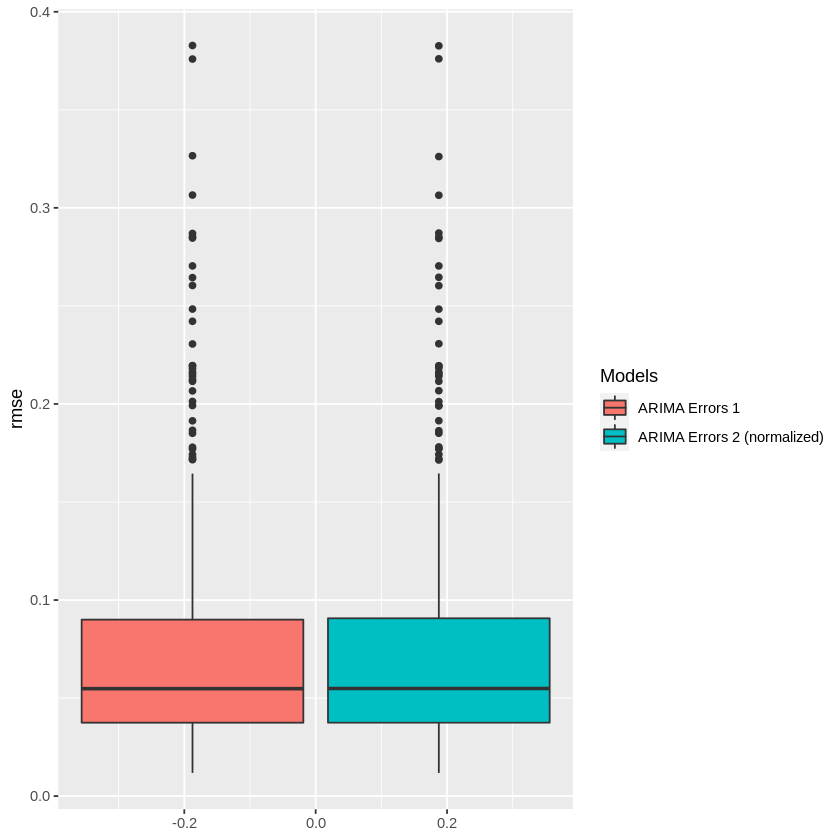

In [26]:
errors.m03.1 <- my.get_result(result.m03.1, 'ARIMA Errors 1')
errors.m03.2 <- my.get_result(result.m03.2, 'ARIMA Errors 2 (normalized)')

x <- rbind(errors.m03.1, errors.m03.2)

my.plot_errors(x, metrics=c('rmse'), loc='right')

In [31]:
# temp saving
write.csv(result.m02, file="result.m02.csv")
write.csv(result.m03.1, file="result.m03.1.csv")
write.csv(result.m03.2, file="result.m03.2.csv")

## Regressor mean of smaller period for forecast 
- Regressor mean for forecast is calculated from the number of latest 'horizon' period
- the 1st model used the number of latest 'window' period for the calc of regressor mean

In [25]:
result.m03.3 <- my.tsCV(trainx[,1], cv.forecast, h=hori, window=wind, step=peri,
                      xreg.msize=hori,
                      xreg=trainx[,2:4])

In [ ]:
x <- result.m03.3
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

## Compare Errors

In [ ]:
my.figsize(10,6)

In [ ]:
errors.m03.1 <- my.get_result(result.m03.1, 'ARIMA Errors 1')
errors.m03.2 <- my.get_result(result.m03.2, 'ARIMA Errors 2 (normalized)')
n <- paste('ARIMA Errors 3 (future regressor mean of', hori ,'days)', sep=' ')
errors.m03.3 <- my.get_result(result.m03.3, n)

x <- rbind(errors.m03.1, errors.m03.2)
x <- rbind(x, errors.m03.3)

my.plot_errors(x, metrics=c('rmse'), loc='right')

In [ ]:
result.m03 <- result.m03.3
#errors.m03 <- errors.m03.3

# ARIMA+GARCH

In [ ]:
cv.forecast <- function(x, h) {
    forc <- ag2.forecast(x, h, out.sample=0)
    if (!is.na(forc)) {
        fc <- list(method = "ARIMA+GARCH Forecasting", mean=forc@forecast$seriesFor[,1])
        attr(fc$mean, "names") <- NULL
        return(fc)
    }
}

In [ ]:
result.m04 <- my.tsCV(train, cv.forecast, h=hori, window=wind, step=peri)

In [ ]:
x <- result.m04
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

In [ ]:
my.figsize(7,7)

In [ ]:
errors.m04 <- my.get_result(result.m04, 'ARIMA+GARCH')
my.plot_errors(errors.m04, metrics=c('rmse'))

# Gradient Boosting

# Model Comparision

In [ ]:
my.figsize(10,6)

In [ ]:
#errors.m01 <- my.get_result(result.m01, 'Prophet')
errors.m02 <- my.get_result(result.m02, '2. ARIMA')
errors.m03 <- my.get_result(result.m03, '3. ARIMA Errors')
errors.m04 <- my.get_result(result.m04, '4. ARIMA+GARCH')
#errors.m05 <- my.get_result(result.m04, 'Gradient Boosting')

In [ ]:
errors.list <- c(errors.m02, errors.m03, errors.m04)
x <- error.list[1]
for (e in errors.list) {
    x <- rbind(x, e)
}

my.figsize(10, 6)
my.plot_errors(x, metrics=c('rmse'), loc='right')